# objective :
<br>Applying knn to classify the amazon food reviews.

In [1]:
import sqlite3 as s
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix


C:\Users\himateja\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
con=s.connect("database.sqlite")
con

In [3]:
data=pd.read_sql_query("SELECT * FROM Reviews WHERE Score!=3",con)
data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
#function to change the score to positive/negative
def change(x):
    if x<3:
        return 'negative'
    else:
        return 'positive'

In [5]:
a_s=data.Score
a_s=a_s.map(change)
data.Score=a_s
data.Score.head(5)

0    positive
1    negative
2    positive
3    negative
4    positive
Name: Score, dtype: object

# Data cleaning

The data needs to get clean as it may have some unwanted things such as duplicates.

In [6]:
#sorting the values by product ids
data=data.sort_values("ProductId")

In [7]:
#removing the duplicates from the data
final_data=data.drop_duplicates(subset={"UserId","Text","ProfileName","Time"},keep="first",inplace=False)

In [8]:
print(final_data.shape)
print(final_data.Score.value_counts())

(364173, 10)
positive    307063
negative     57110
Name: Score, dtype: int64


In [9]:
p_data=final_data[final_data.Score=="positive"]
n_data=final_data[final_data.Score=="negative"]

In [14]:
#randomly selecting points
p_data=p_data.sample(17000)
n_data=n_data.sample(3000)
p_8=p_data.head(8000)
n_8=n_data.head(2000)

In [15]:
print(p_data.shape,n_data.shape,p_8.shape,n_8.shape)

(17000, 10) (3000, 10) (8000, 10) (2000, 10)


In [16]:
#d is to use for brute force and kd is to use for kd_tree
d=pd.concat((p_data,n_data))
kd=pd.concat((p_8,n_8))

In [18]:
print(d.shape,kd.shape)

(20000, 10) (10000, 10)


In [19]:
#sorting according to time stamp
d=d.sort_values('Time')
kd=kd.sort_values('Time')

In [20]:
print(d.Score.value_counts(),kd.Score.value_counts())

positive    17000
negative     3000
Name: Score, dtype: int64 positive    8000
negative    2000
Name: Score, dtype: int64


# Data preprocessing

The data should be preprocessed after cleaning it

In [21]:
import string 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

In [22]:
#stopwords
stop_words=set(stopwords.words("english"))
#initializing snowball stemmer
sno=SnowballStemmer("english")

In [23]:
#function to remove html tags
def cleanhtml(s):
    cleanr=re.compile("<.*?>")
    cleant=re.sub(cleanr," ",s)
    return cleant

In [24]:
#funtion to remove punctuation and special character
def cleanpunc(s): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',s)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


In [25]:
i=0
final=[]

for s in d.Text.values:
    f=[]
    c=cleanhtml(s)
    for w in cleanpunc(c).split():
        if w.isalpha() and len(w)>2:
            if w not in stop_words:
                sne=(sno.stem(w.lower())).encode('utf-8')
                f.append(sne)
               
            else:
                continue
        else:
            continue
    te=b" ".join(f)
    final.append(te)
    i+=1

In [26]:
#adding the preprocessed data into another column
d["cleaned"]=final

In [27]:
i=0
kfinal=[]

for s in kd.Text.values:
    f=[]
    c=cleanhtml(s)
    for w in cleanpunc(c).split():
        if w.isalpha() and len(w)>2:
            if w not in stop_words:
                sne=(sno.stem(w.lower())).encode('utf-8')
                f.append(sne)
               
            else:
                continue
        else:
            continue
    te=b" ".join(f)
    kfinal.append(te)
    i+=1

In [28]:
kd["cleaned"]=kfinal

In [31]:
#checking if new column is added
d.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'cleaned'],
      dtype='object')

In [32]:
#checking if the column is added
kd.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'cleaned'],
      dtype='object')

In [33]:
import sqlite3
conn=sqlite3.connect("future.sqlite")
c=conn.cursor()
conn.text_factory=str
d.to_sql('Reviews',conn,if_exists='replace',index=True)

Lets create two functions for brute force and kd_tree,so, that we don't have to write it again and again

In [74]:
#function for brute force algorithm
def main(h,j,k,l):
    #gridsearchcv

    #params we need to try on classifier
    knn = KNeighborsClassifier(algorithm='brute')
    param_grid = {'n_neighbors':np.arange(1,40,2)} 
    #For time based splitting
    t = TimeSeriesSplit(n_splits=5) 
    gsv = GridSearchCV(knn,param_grid,cv=t)
    gsv.fit(h,j)
    print("Best HyperParameter: ",gsv.best_params_)
    print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
    print("best estimator: ",gsv.estimator)
    gsv.estimator.fit(h,j)
    pred=gsv.estimator.predict(k)
    #accuracy
    acc=accuracy_score(l,pred)*100
    print("the accuracy is %.2f%%"%acc)
    df_cm=pd.DataFrame(confusion_matrix(l,pred))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm,annot=True,fmt="d")
    
    
    

In [46]:
#function for kd_tree
def kmain(h,j,k,l):
    #gridsearchcv

    #params we need to try on classifier
    knn = KNeighborsClassifier(algorithm='kd_tree')
    param_grid = {'n_neighbors':np.arange(1,40,2)} 
    #For time based splitting
    t = TimeSeriesSplit(n_splits=5) 
    gsv = GridSearchCV(knn,param_grid,cv=t)
    gsv.fit(h,j)
    print("Best HyperParameter: ",gsv.best_params_)
    print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
    print("best estimator: ",gsv.estimator)
    gsv.estimator.fit(h,j)
    pred=gsv.estimator.predict(k)
    #accuracy
    acc=accuracy_score(l,pred)*100
    print("the accuracy is %.2f%%"%acc)
    df_cm=pd.DataFrame(confusion_matrix(l,pred))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm,annot=True,fmt="d")
    

# Bag of words

Brute Force algorithm

In [107]:
x_1, x_test, y_1, y_test = train_test_split(d.cleaned.values, d.Score, test_size=0.3, random_state=0,shuffle=False)

#x_tr, x_cv, y_tr, y_cv = train_test_split(x_1, y_1, test_size=0.3)

In [108]:
print(x_1.shape,x_test.shape,y_1.shape,y_test.shape)

(14000,) (6000,) (14000,) (6000,)


In [109]:
from sklearn.feature_extraction.text import CountVectorizer

In [110]:
#bigrams
count_vect=CountVectorizer(ngram_range=(1,2))

In [111]:
bdata=count_vect.fit_transform(x_1)

test_data=count_vect.transform(x_test)
print(bdata.shape,y_1.shape,test_data.shape,y_test.shape)

(14000, 308946) (14000,) (6000, 308946) (6000,)


Best HyperParameter:  {'n_neighbors': 7}
Best Accuracy: 84.62%
best estimator:  KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
the accuracy is 83.82%
Wall time: 5min 6s


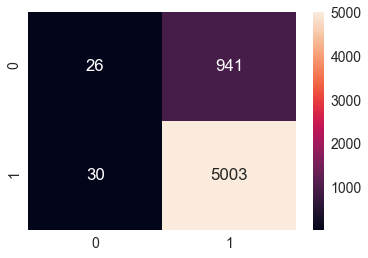

In [112]:
%%time
main(bdata,y_1,test_data,y_test)

Kdtree algorithm

In [121]:
from sklearn.decomposition import TruncatedSVD

In [122]:
x_1, x_test, y_1, y_test = train_test_split(kd.cleaned.values, kd.Score, test_size=0.3, random_state=0,shuffle=False)

#x_tr, x_cv, y_tr, y_cv = train_test_split(x_1, y_1, test_size=0.3)

In [123]:
#bigrams
count_vect=CountVectorizer(ngram_range=(1,2))

In [124]:
bdata=count_vect.fit_transform(x_1)

test_data=count_vect.transform(x_test)
print(bdata.shape,y_1.shape,test_data.shape,y_test.shape)

(7000, 181833) (7000,) (3000, 181833) (3000,)


In [117]:
#reducing dimension to 1500
T=TruncatedSVD(1500)
bdata=T.fit_transform(bdata)
bdata.shape

(7000, 1500)

In [118]:
print(T.explained_variance_ratio_.sum())

0.7581585063506087


In [119]:
test_data=T.transform(test_data)
test_data.shape

(3000, 1500)

Best HyperParameter:  {'n_neighbors': 7}
Best Accuracy: 80.09%
best estimator:  KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
the accuracy is 79.20%
Wall time: 1h 32min 21s


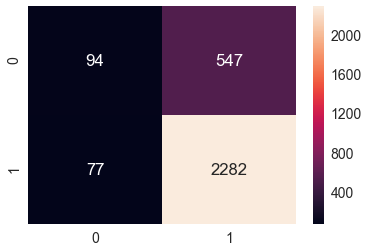

In [120]:
%%time
#kd_tree with high dimensionality
kmain(bdata,y_1,test_data,y_test)

In [125]:
#reducing dimendion to 5
T=TruncatedSVD(5)
bdata=T.fit_transform(bdata)
bdata.shape

(7000, 5)

In [126]:
test_data=T.transform(test_data)
test_data.shape

(3000, 5)

Best HyperParameter:  {'n_neighbors': 23}
Best Accuracy: 79.35%
best estimator:  KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
the accuracy is 76.10%
Wall time: 7.73 s


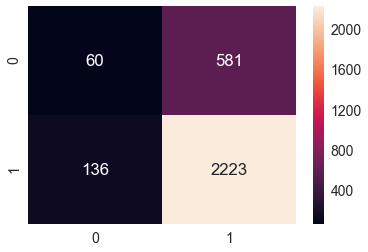

In [127]:
%%time
#kd_tree with small dimensionality
kmain(bdata,y_1,test_data,y_test)

Summary:
    <br>brute force : accuracy is 84.62 and TP is also high 
    <br>kd_tree : with high dimension we got accuray as 80% and small dimension gave 79.35% but the thing to notice is that kd_tree with high dimension takes a lot of time than with smaller dimension.

# Tfidf

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer

brute force algorithm

In [95]:
x_1, x_test, y_1, y_test = train_test_split(d.cleaned.values, d.Score, test_size=0.3, random_state=0,shuffle=False)

#x_tr, x_cv, y_tr, y_cv = train_test_split(x_1, y_1, test_size=0.3)

In [96]:
#bigrams
tfidf=TfidfVectorizer(ngram_range=(1,2))

In [97]:
tdata=tfidf.fit_transform(x_1)
test_data=tfidf.transform(x_test)
print(tdata.shape,test_data.shape)

(14000, 308946) (6000, 308946)


Best HyperParameter:  {'n_neighbors': 7}
Best Accuracy: 85.43%
best estimator:  KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
the accuracy is 84.85%
Wall time: 5min 25s


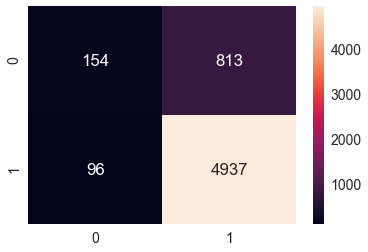

In [98]:
%%time
main(tdata,y_1,test_data,y_test)

Kd tree

In [99]:
from sklearn.decomposition import TruncatedSVD

In [100]:
x_1, x_test, y_1, y_test = train_test_split(kd.cleaned.values, kd.Score, test_size=0.3, random_state=0,shuffle=False)

#x_tr, x_cv, y_tr, y_cv = train_test_split(x_1, y_1, test_size=0.3)

In [101]:
#bigrams
tfidf=TfidfVectorizer(ngram_range=(1,2))

In [102]:
tdata=tfidf.fit_transform(x_1)
test_data=tfidf.transform(x_test)
print(tdata.shape,test_data.shape)

(7000, 181833) (3000, 181833)


In [103]:
#reducing the dimensionality to 5
T=TruncatedSVD(1500)
tdata=T.fit_transform(tdata)
tdata.shape

(7000, 1500)

In [104]:
print(T.explained_variance_ratio_.sum())

0.41182636359860186


In [105]:
test_data=T.transform(test_data)
test_data.shape

(3000, 1500)

Best HyperParameter:  {'n_neighbors': 7}
Best Accuracy: 80.55%
best estimator:  KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
the accuracy is 79.77%
Wall time: 1h 24min 40s


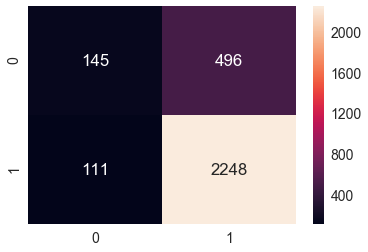

In [106]:
%%time
#kd_tree with high dimensionality
kmain(tdata,y_1,test_data,y_test)

In [90]:
#reducing the dimensionality to 5
T=TruncatedSVD(5)
tdata=T.fit_transform(tdata)
tdata.shape

(7000, 5)

In [91]:
test_data=T.transform(test_data)
test_data.shape

(3000, 5)

Best HyperParameter:  {'n_neighbors': 21}
Best Accuracy: 79.40%
best estimator:  KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
the accuracy is 75.23%
Wall time: 7.8 s


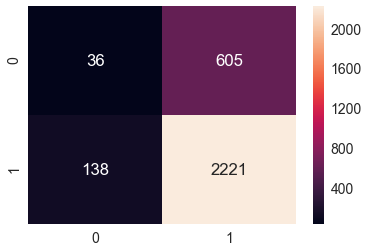

In [93]:
%%time
#kd_tree with small dimensionality
kmain(tdata,y_1,test_data,y_test)

Summary:
    <br>brute force : accuracy is 85.43 and TP is also high 
    <br>kd_tree : with high dimension we got accuray as 80.55% and small dimension gave 79.40% but the thing to notice is that kd_tree with high dimension takes a lot of time than with smaller dimension.

# Word2Vec

In [62]:
from gensim.models import Word2Vec
#making list of sentences
import string
i=0
list_s=[]
for s in d.Text.values:
    filtered=[]
    s=cleanhtml(s)
    for w in s.split():
        for c_w in cleanpunc(w).split():
            if c_w.isalpha():
                filtered.append(c_w.lower())
            else:
                continue
    list_s.append(filtered)
#training our own model
w2v_model=Word2Vec(list_s,min_count=5,size=50,workers=4)

C:\Users\himateja\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Average word2vec

In [78]:
#creating avg word2vec
sv=[]
for s in list_s:
    sum=np.zeros(50)
    i=0
    for w in s:
        try:
            
            x=w2v_model.wv[w]
            sum+=x
            i+=1
        except:
            pass
    sum/=i
    sv.append(sum)
    
#cheking the dimension
print(len(sv))
print(len(sv[0]))

20000
50


In [79]:
x=np.asarray(sv)
y=d.Score

brute force algorithm

In [80]:
x_1, x_test, y_1, y_test = train_test_split(x, y, test_size=0.3, random_state=0,shuffle=False)

#x_tr, x_cv, y_tr, y_cv = train_test_split(x_1, y_1, test_size=0.3)

Best HyperParameter:  {'n_neighbors': 11}
Best Accuracy: 85.36%
best estimator:  KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
the accuracy is 83.77%
Wall time: 3min 5s


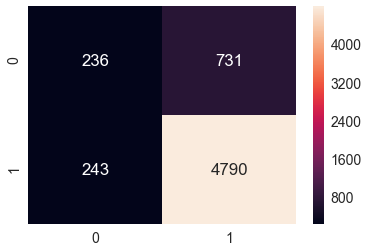

In [81]:
%%time
main(x_1,y_1,x_test,y_test)

kd_tree algorithm

Best HyperParameter:  {'n_neighbors': 11}
Best Accuracy: 85.36%
best estimator:  KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
the accuracy is 83.77%
Wall time: 11min 36s


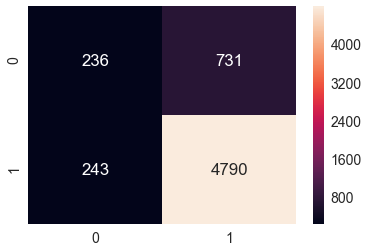

In [82]:
%%time
kmain(x_1,y_1,x_test,y_test)

Summary:
    <br>brute force : accuracy is 85.36 and TP is also high .
    <br>kd_tree : with high dimension we got accuray as 85.36% .

# Tfidf word2vec

In [68]:
tfidf_feat = tfidf.get_feature_names()
tf=tfidf.fit_transform(d.Text.values)
tfidfsv = []
row=0;
for s in list_s: 
    sum = np.zeros(50) 
    i=0; 
    for word in s: 
        try:
            vec = w2v_model.wv[word]
            tf_idf = tf[row, tfidf_feat.index(word)]
            sum += (vec * tf_idf)
            i += tf_idf
        except:
            pass
    sum /= i
    tfidfsv.append(sum)
    row += 1

C:\Users\himateja\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [70]:
x=np.asarray(tfidfsv)
y=d.Score
x

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

brute force algorithm

In [71]:
#splitting of the data
x_1, x_test, y_1, y_test = train_test_split(x, y, test_size=0.3,shuffle=False)

#x_tr, x_cv, y_tr, y_cv = train_test_split(x_1, y_1, test_size=0.3)

The 'x' array has 'NaN' values we have to change them .

In [72]:
# changing 'NaN' to numeric value
x_1=np.isnan(x_1)
np.where(np.isnan(x_1))
np.nan_to_num(x_1)

x_test=np.isnan(x_test)
np.where(np.isnan(x_test))
np.nan_to_num(x_test)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

Best HyperParameter:  {'n_neighbors': 1}
Best Accuracy: 84.56%
best estimator:  KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
the accuracy is 83.88%
Wall time: 2min 27s


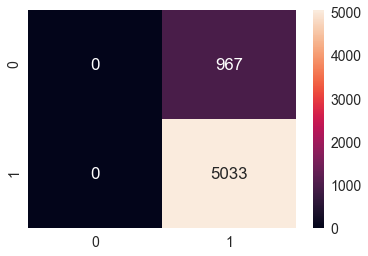

In [76]:
%%time
main(x_1,y_1,x_test,y_test)

kd_tree algorithm

Best HyperParameter:  {'n_neighbors': 5}
Best Accuracy: 84.56%
best estimator:  KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
the accuracy is 83.88%
Wall time: 8min 50s


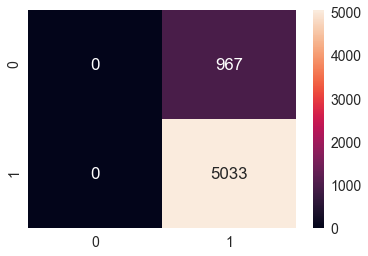

In [77]:
%%time
kmain(x_1,y_1,x_test,y_test)

Summary:
    <br>brute force : accuracy is 83.88 and TP is also high .
    <br>kd_tree : with high dimension we got accuray as 83.88% .

# Conclusion :
<br>brute force
<br>accuracy:
<br>bag of words : 84.62%
<br>tfidf        :85.43%
<br>avg word2vec :85.36%
<br>tfidf word2vec:83.88%
<br><br>the accuracy are good and even the TP of confusion matrix are high.so the model are doing good.


kd_tree:<br>
<br>bagofwords:<br>
time for 1500 dimension =  1h 32min 21s<br>
time for 5 dimension = 7.73s
<br><br>
tfidf:<br>
time for 1500 dimension = 1h 24min 40s<br>
time for 5 dimension = 7.8s

<br>1.The more the data ,more will be the accuracy.
<br>2.you cannot pass sparse matrix to the kdtree.
<br>3.kd_tree works well with only when dimensionality is small.
<br>4.doing cross validation can increase your train data which increases your accuracy as we know more the data more is the accuracy.